In [187]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc, cm
from matplotlib.ticker import FixedLocator
import os.path as osp
import os
import cartopy.crs as ccrs
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Point, LineString, Polygon
from shapely import geometry
from cartopy.feature import ShapelyFeature
import networkx as nx
import itertools as it
from PIL import ImageColor
import xarray as xr
from shapely.ops import cascaded_union

In [190]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 12})

dpi = 100

c_radar_loc = '#cc3300'
c_radar_area = '#347B98'
c_boundary = '#092834'
c_boundary_rgb = (9/255, 40/255, 52/255, 0.2)
c_boundary_light = '#0a3142'
c_text = '#262626'
c_countries = 'lightgray'

In [202]:
root = '/home/fiona/birdMigration'
# root = '/media/fiona/Seagate Basic/PhD/paper_1/'
target_dir = osp.join(root, 'data/plots/final')
os.makedirs(target_dir, exist_ok=True)

voronoi = gpd.read_file(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp'))
voronoi = voronoi.to_crs(epsg=4326)

voronoi_b = gpd.read_file(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp'))
voronoi_b = voronoi_b.to_crs(epsg=4326)

delaunay_b = nx.read_gpickle(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'))

radar_buffers = gpd.read_file(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/radar_buffers.shp'))
radars = radar_buffers.centroid.to_crs(epsg=4326)

radar_buffers_b = gpd.read_file(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/radar_buffers.shp'))
radars_b = radar_buffers_b.centroid.to_crs(epsg=4326)

countries = gpd.read_file(osp.join(root, 'data/shapes/ne_10m_admin_0_countries_lakes.shp'))

extent = voronoi_b.total_bounds
extent[1] -= 0.5
crs = ccrs.AlbersEqualArea(central_longitude=voronoi.lon.mean(), central_latitude=voronoi.lat.mean())

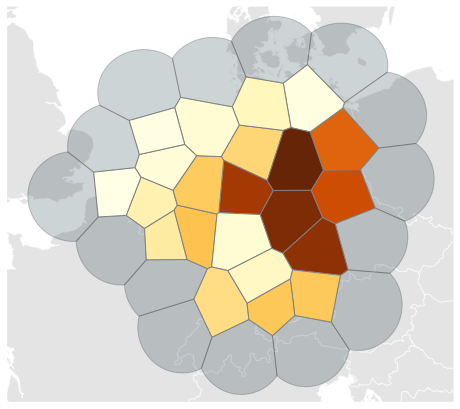

In [421]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white', alpha=0.6)
ax.add_feature(f, facecolor=c_countries, zorder=0)

cmap = cm.get_cmap('YlOrBr')
# r_high = ['defbg', 'demem']
# r_high = ['defbg', 'deisn', 'demem', 'deeis', 'deoft', 'deneu', 'detur']
# r_high = ['defld', 'deneu', 'dedrs', 'deeis', 'deoft', 'detur']
r_high = ['defld', 'deneu', 'dedrs', 'deeis', 'deumd', 'depro']
voronoi_b['rand'] = [np.random.rand() + 1.5 if row.radar in r_high else np.random.rand() for i, row in voronoi_b.iterrows()]
#voronoi_b.loc[voronoi_b.radar.isin(['defld', 'deneu', 'dedrs'])]['rand'] = voronoi_b[voronoi_b.radar.isin(['defld', 'deneu', 'dedrs'])]['rand'].apply(lambda x: x+100)

gplt.polyplot(voronoi_b.query('boundary == 1'), ax=ax, facecolor=c_boundary, alpha=0.2, extent=extent, zorder=2)
gplt.choropleth(voronoi_b.query('boundary == 0'), ax=ax, hue='rand', cmap = cmap, edgecolor='gray', 
                alpha=1, extent=extent, zorder=2)

#gplt.pointplot(radars, ax=ax, extent=extent, zorder=3, color=c_radar_loc, s=4)

fig.savefig(osp.join(target_dir, f'bird_densities_1.png'), bbox_inches='tight', dpi=dpi, transparent=False)

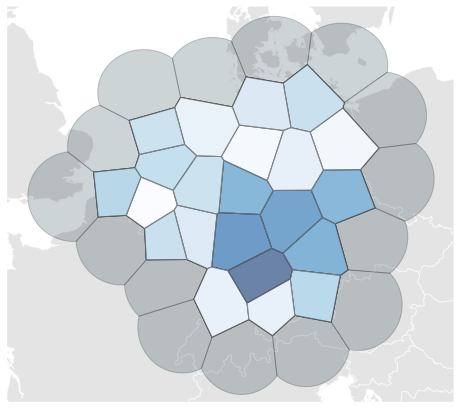

In [426]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

# G = delaunay_b.to_undirected()
# boundary_edges = [(u[0], v[0]) for u, v in it.combinations(list(G.nodes(data=True)), 2) if u[1]['boundary'] and v[1]['boundary']]
# G.remove_edges_from(boundary_edges)

# coord_df = gpd.GeoDataFrame(dict(radar = voronoi_b.radar, 
#                              geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi_b.iterrows()]), 
#                             crs='epsg:4326').to_crs(crs.proj4_init)
# pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
#        (ridx, name) in nx.get_node_attributes(delaunay_b, 'radar').items()}

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0, alpha=0.6)

cmap = cm.get_cmap('Blues')
r_high = ['defld', 'deneu', 'dedrs', 'deeis', 'deoft', 'detur']
# r_high = ['defld', 'deneu', 'dedrs', 'deeis', 'deumd']
voronoi_b['rand'] = [np.random.rand() + 1.2 if row.radar in r_high else np.random.rand() for i, row in voronoi_b.iterrows()]
#voronoi_b.loc[voronoi_b.radar.isin(['defld', 'deneu', 'dedrs'])]['rand'] = voronoi_b[voronoi_b.radar.isin(['defld', 'deneu', 'dedrs'])]['rand'].apply(lambda x: x+100)
#voronoi_b['rand'] = [np.random.rand() for i, row in voronoi_b.iterrows()]

gplt.polyplot(voronoi_b.query('boundary == 1'), ax=ax, facecolor=c_boundary, alpha=0.2, extent=extent, zorder=2)
gplt.polyplot(voronoi_b.query('boundary == 0'), ax=ax, facecolor='white', extent=extent, zorder=2)
gplt.choropleth(voronoi_b.query('boundary == 0'), ax=ax, hue='rand', cmap = cmap, edgecolor='gray', 
                alpha=0.6, extent=extent, zorder=3)

#gplt.pointplot(radars, ax=ax, extent=extent, zorder=3, color=c_radar_loc, s=4)

fig.savefig(osp.join(target_dir, f'takeoff_landing_2.png'), bbox_inches='tight', dpi=dpi, transparent=False)

In [443]:
# prepare graph
G = delaunay_b.copy()
boundary_edges = [(u[0], v[0]) for u, v in it.permutations(list(G.nodes(data=True)), 2) if u[1]['boundary'] and v[1]['boundary']]
G.remove_edges_from(boundary_edges)

# r_high = ['defbg', 'deisn', 'demem', 'deeis', 'deoft', 'deneu', 'detur']
r_high = ['defld', 'deneu', 'dedrs', 'deeis', 'deoft', 'detur']
# r_high = ['defld', 'deneu', 'dedrs', 'deeis', 'deumd']

def reverse(radar1, radar2):
    x1 = voronoi_b.query(f'radar == "{radar1}"').x.values[0]
    x2 = voronoi_b.query(f'radar == "{radar2}"').x.values[0]
    y1 = voronoi_b.query(f'radar == "{radar1}"').y.values[0]
    y2 = voronoi_b.query(f'radar == "{radar2}"').y.values[0]
    
    if x1 > x2: # and y1 > y2:
        return False
    else:
        return True

reverse_edges = [(u[0], v[0]) for u, v in it.permutations(list(G.nodes(data=True)), 2) if reverse(u[1]['radar'], v[1]['radar'])]
G.remove_edges_from(reverse_edges)

coord_df = gpd.GeoDataFrame(dict(radar = voronoi_b.radar, 
                             geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi_b.iterrows()]), 
                            crs='epsg:4326').to_crs(crs.proj4_init)
pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
       (ridx, name) in nx.get_node_attributes(delaunay_b, 'radar').items()}

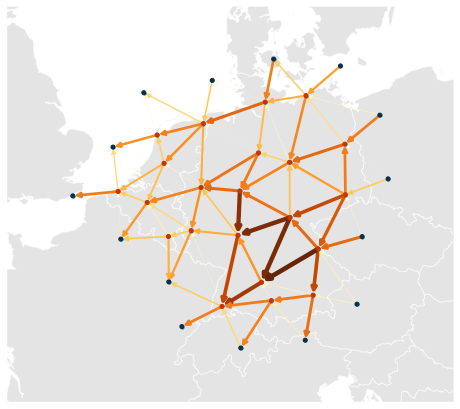

In [446]:
def flux(ridx1, ridx2):
    radar1 = G.nodes(data=True)[ridx1]['radar']
    radar2 = G.nodes(data=True)[ridx2]['radar']
    
    x1 = voronoi_b.query(f'radar == "{radar1}"').x.values[0]
    x2 = voronoi_b.query(f'radar == "{radar2}"').x.values[0]
    y1 = voronoi_b.query(f'radar == "{radar1}"').y.values[0]
    y2 = voronoi_b.query(f'radar == "{radar2}"').y.values[0]
    
    flux = np.random.rand()
    if x1 > x2 and y1 > y2:
        flux += 1
    if radar1 in r_high:
        flux += 1
        
    return flux

fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0, alpha=0.6)

cmap = cm.get_cmap('YlOrBr')

fluxes = np.array([flux(u, v) for u, v in G.edges()])
edge_colors = fluxes / fluxes.max()
edge_colors = cmap(edge_colors)

nx.draw(G, pos=pos, with_labels=False, node_size=10, ax=ax, zorder=4, width = fluxes * 1.6,
            options={'arrowsize': fluxes * 100}, edge_color=edge_colors) #, connectionstyle="arc3,rad=0.1")


# gplt.polyplot(voronoi_b.query('boundary == 1'), ax=ax, facecolor=c_boundary, alpha=0.2, extent=extent, zorder=2)
# gplt.polyplot(voronoi_b.query('boundary == 0'), ax=ax, edgecolor=c_boundary_light, alpha=0.2, extent=extent, zorder=2)

gplt.pointplot(radars, ax=ax, extent=extent, zorder=3, color=c_radar_loc, s=4)
gplt.pointplot(radars_b[voronoi_b.query('boundary == 1').index], ax=ax, extent=extent, zorder=3, color=c_boundary_light, s=4)

#gplt.pointplot(radars, ax=ax, extent=extent, zorder=3, color=c_radar_loc, s=4)

fig.savefig(osp.join(target_dir, f'fluxes_1.png'), bbox_inches='tight', dpi=dpi, transparent=False)

In [80]:
ds = xr.open_dataset(osp.join(root, 'data/raw/env/fall/2015/buffer_4_4/pressure_level_850.nc'))
ds_coarse = ds.isel(latitude=slice(0, 66))
ds_coarse = ds_coarse.coarsen(longitude=3).mean().coarsen(latitude=3).mean()

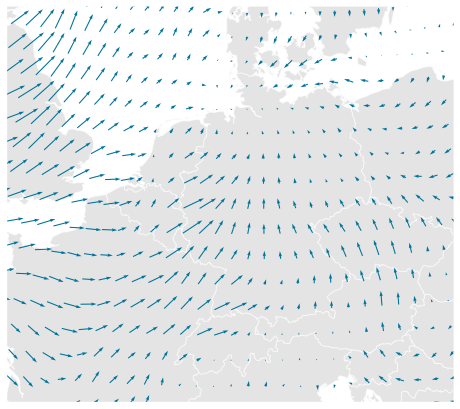

In [171]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

tidx = 80

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0, alpha=0.6)

# b = 500
# outside = gpd.GeoSeries([Polygon([
#     Point(voronoi_b.total_bounds[0]-b, voronoi_b.total_bounds[1]-b),
#     Point(voronoi_b.total_bounds[0]-b, voronoi_b.total_bounds[3]+b),
#     Point(voronoi_b.total_bounds[2]+b, voronoi_b.total_bounds[3]+b),
#     Point(voronoi_b.total_bounds[2]+b, voronoi_b.total_bounds[1]-b)])], crs='EPSG:4326')
# outside = outside.difference(cascaded_union(voronoi_b.geometry))

ax.quiver(ds_coarse.longitude.values, ds_coarse.latitude.values, 
          ds_coarse.u.isel(time=tidx).values, ds_coarse.v.isel(time=0).values, 
          transform=ccrs.PlateCarree(), color='#007399', zorder=1)

gplt.polyplot(voronoi_b.query('boundary == 1'), ax=ax, alpha=0, extent=extent, zorder=2)
# gplt.polyplot(voronoi_b.query('boundary == 0'), ax=ax, alpha=0.2, extent=extent, zorder=2)
# gplt.polyplot(outside, ax=ax, facecolor='white', alpha=1, extent=extent, zorder=3)

fig.savefig(osp.join(target_dir, f'wind_1.png'), bbox_inches='tight', dpi=dpi, transparent=False)

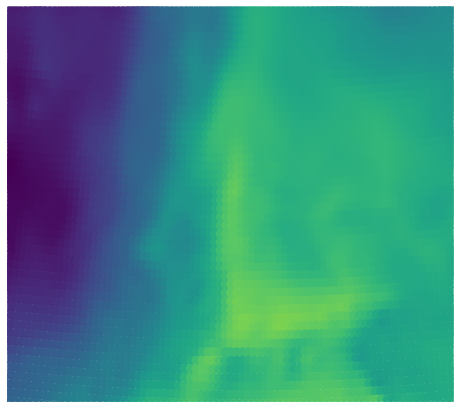

In [182]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

tidx = 80
f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0, alpha=0.6)

# b = 500
# outside = gpd.GeoSeries([Polygon([
#     Point(voronoi_b.total_bounds[0]-b, voronoi_b.total_bounds[1]-b),
#     Point(voronoi_b.total_bounds[0]-b, voronoi_b.total_bounds[3]+b),
#     Point(voronoi_b.total_bounds[2]+b, voronoi_b.total_bounds[3]+b),
#     Point(voronoi_b.total_bounds[2]+b, voronoi_b.total_bounds[1]-b)])], crs='EPSG:4326')
# outside = outside.difference(cascaded_union(voronoi_b.geometry))

df = ds.isel(time=tidx).to_dataframe().reset_index()
gdf = gpd.GeoDataFrame(
    df.t, geometry=gpd.points_from_xy(df.longitude,df.latitude))
gplt.pointplot(gdf, extent=extent, hue='t', ax=ax, s=9, alpha=1)

gplt.polyplot(voronoi_b.query('boundary == 1'), edgecolor='white', ax=ax, alpha=0, extent=extent, zorder=2)
# gplt.polyplot(voronoi_b.query('boundary == 0'), edgecolor='white', ax=ax, alpha=0.2, extent=extent, zorder=2)
# gplt.polyplot(outside, ax=ax, facecolor='white', alpha=1, extent=extent, zorder=3)

fig.savefig(osp.join(target_dir, f'temp_1.png'), bbox_inches='tight', dpi=dpi, transparent=False)

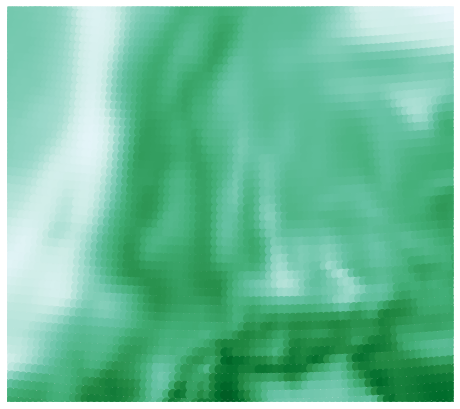

In [186]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

tidx = 80
f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0, alpha=0.6)

# b = 500
# outside = gpd.GeoSeries([Polygon([
#     Point(voronoi_b.total_bounds[0]-b, voronoi_b.total_bounds[1]-b),
#     Point(voronoi_b.total_bounds[0]-b, voronoi_b.total_bounds[3]+b),
#     Point(voronoi_b.total_bounds[2]+b, voronoi_b.total_bounds[3]+b),
#     Point(voronoi_b.total_bounds[2]+b, voronoi_b.total_bounds[1]-b)])], crs='EPSG:4326')
# outside = outside.difference(cascaded_union(voronoi_b.geometry))

df = ds.isel(time=tidx).to_dataframe().reset_index()
gdf = gpd.GeoDataFrame(
    df.q, geometry=gpd.points_from_xy(df.longitude,df.latitude))
gplt.pointplot(gdf, extent=extent, hue='q', ax=ax, s=9, alpha=1, cmap=cm.BuGn)

gplt.polyplot(voronoi_b.query('boundary == 1'), edgecolor='white', ax=ax, alpha=0, extent=extent, zorder=2)
# gplt.polyplot(voronoi_b.query('boundary == 0'), edgecolor='white', ax=ax, alpha=0.2, extent=extent, zorder=2)
# gplt.polyplot(outside, ax=ax, facecolor='white', alpha=1, extent=extent, zorder=3)

fig.savefig(osp.join(target_dir, f'humidity_1.png'), bbox_inches='tight', dpi=dpi, transparent=False)